In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

seed = 420
tf.random.set_seed(seed)
np.random.seed(seed)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']



6577
(800, 513)


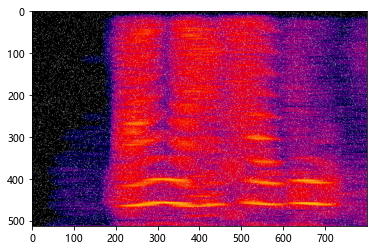

In [2]:
import pathlib
data_dir_train = 'Dataset/audioNet1/train'
#data_dir_train = 'Dataset/audioNet0'
data_dir_train = pathlib.Path(data_dir_train)

data_dir_test = 'Dataset/audioNet1/test'
data_dir_test = pathlib.Path(data_dir_test)

image_count = len(list(data_dir_train.glob('*/*.png')))
print(image_count)

entry0 = list(data_dir_train.glob('0/*'))
im = Image.open(str(entry0[0]))
plt.imshow(im)
print(im.size)


In [3]:
# Load using keras.preprocessing
batch_size = 32
img_height = 513//3
img_width = 800//3

seed = 42
validation_split = 0.15
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            validation_split=validation_split,
            subset="training",
            seed=seed,
            image_size=(img_height, img_width),
            batch_size=batch_size)
print()
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            validation_split=validation_split,
            subset="validation",
            seed=seed,
            image_size=(img_height, img_width),
            batch_size=batch_size)
print()
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_test,
            seed=seed,
            image_size=(img_height, img_width),
            batch_size=batch_size)

class_names = train_ds.class_names
print('\n', class_names)



Found 6577 files belonging to 24 classes.
Using 5591 files for training.

Found 6577 files belonging to 24 classes.
Using 986 files for validation.

Found 710 files belonging to 24 classes.

 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9']


(32, 171, 266, 3)
(32,)


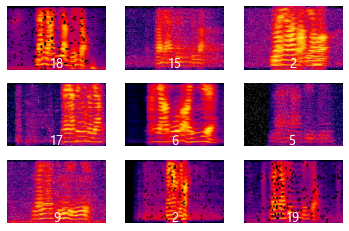

In [4]:
# Visualize the data
#plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], y=-0.06, c='w')
        plt.axis("off")

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    


In [5]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [6]:
# Create the model

num_classes = len(class_names)

norm_layer = layers.experimental.preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

In [7]:
# Droupout on conv2D should <= 0.2

""" model = Sequential([
    #data_augmentation,
    layers.Input(shape=(img_height, img_width, 3)),
    norm_layer,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    
    layers.Dropout(0.5),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((5, 2), strides=(5, 2), padding='same'),
    layers.Dropout(0.5),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    
    layers.Dropout(0.5),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((5, 2), strides=(5, 2), padding='same'),
    layers.Dropout(0.5),
    layers.Conv2D(64, 3, padding='same', activation='relu'),

    layers.Dropout(0.5),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    layers.Dropout(0.5),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((4, 2), strides=(4, 2), padding='same'),

    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    #data_augmentation,
    norm_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((5, 2), padding='same'),
    #layers.Dropout(0.5),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((5, 2), padding='same'),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((4, 2), padding='same'),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Dropout(0.25),

    layers.Reshape([17, 128]), 
    layers.Bidirectional(layers.LSTM(128)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
]) """
# 5542: loss: 0.8436 - accuracy: 0.8540
# 5524: loss: 0.8530 - accuracy: 0.8195
# 2455: loss: 1.1051 - accuracy: 0.7850

ks = (7, 2)
strides = (1, 2)
model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    #data_augmentation,
    norm_layer,
    #layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, ks, strides, padding='same', activation='relu'),
    layers.MaxPooling2D((5, 1), padding='same'),
    #layers.Dropout(0.25),

    layers.Conv2D(32, ks, strides, padding='same', activation='relu'),
    layers.MaxPooling2D((5, 1), padding='same'),
    #layers.Dropout(0.25),

    layers.Conv2D(64, ks, strides, padding='same', activation='relu'),
    layers.MaxPooling2D((4, 1), padding='same'),
    #layers.Dropout(0.25),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    #layers.Dropout(0.25),

    layers.Reshape([17, 128]), 
    layers.Bidirectional(layers.LSTM(128)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(tf.keras.optimizers.Adam(0.0005),#
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 171, 266, 3)       7         
_________________________________________________________________
conv2d (Conv2D)              (None, 171, 133, 16)      688       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 133, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 67, 32)        7200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 67, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 34, 64)         28736     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 34, 64)         0

In [8]:
epochs=500
history = model.fit(
  train_ds,
  #steps_per_epoch=171,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=30, restore_best_weights=True)
)

model.evaluate(val_ds)


Epoch 1/500
175/175 [==============================] - 17s 96ms/step - loss: 3.1805 - accuracy: 0.0467 - val_loss: 3.1782 - val_accuracy: 0.0426
Epoch 2/500
175/175 [==============================] - 5s 29ms/step - loss: 3.1755 - accuracy: 0.0465 - val_loss: 3.1553 - val_accuracy: 0.0507
Epoch 3/500
175/175 [==============================] - 5s 29ms/step - loss: 2.9310 - accuracy: 0.0989 - val_loss: 2.5263 - val_accuracy: 0.1785
Epoch 4/500
175/175 [==============================] - 5s 29ms/step - loss: 2.1857 - accuracy: 0.2695 - val_loss: 1.7886 - val_accuracy: 0.3550
Epoch 5/500
175/175 [==============================] - 5s 29ms/step - loss: 1.5739 - accuracy: 0.4421 - val_loss: 1.1362 - val_accuracy: 0.5842
Epoch 6/500
175/175 [==============================] - 5s 29ms/step - loss: 1.1377 - accuracy: 0.5976 - val_loss: 0.9299 - val_accuracy: 0.6602
Epoch 7/500
175/175 [==============================] - 5s 29ms/step - loss: 0.8312 - accuracy: 0.7153 - val_loss: 0.6759 - val_accuracy

[0.03769601136445999, 0.9959431886672974]

In [9]:
print('Evaluating on Test set......')
model.evaluate(test_ds)


Evaluating on Test set......
23/23 [==============================] - 4s 181ms/step - loss: 0.0261 - accuracy: 0.9986


[0.026143062859773636, 0.9985915422439575]

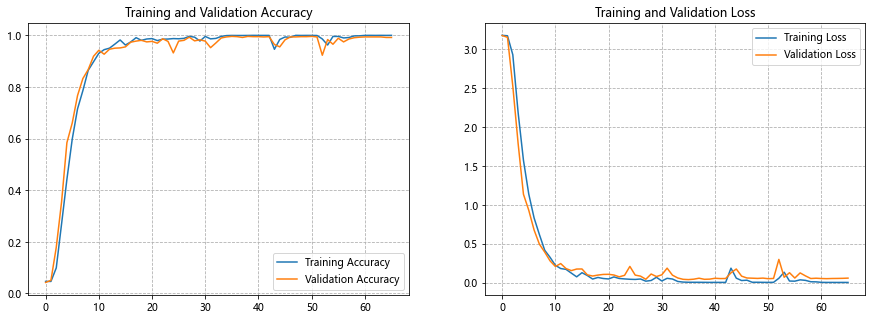

In [10]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(ls='--')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid(ls='--')
plt.title('Training and Validation Loss')
plt.show()


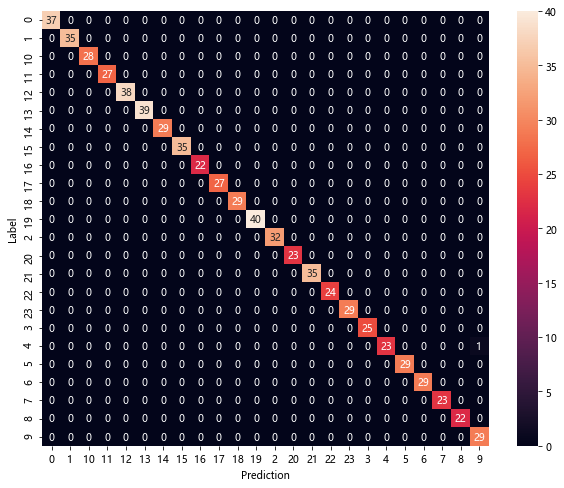

In [11]:
import seaborn as sns

y_true = np.array([i[1] for i in test_ds.unbatch().as_numpy_iterator()])
y_pred = np.argmax(model.predict(test_ds), axis=1)
# y_pred = np.array([i[0] for i in test_ds.unbatch().as_numpy_iterator()])

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [12]:
model.save('model/audioNet9959')



Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/audioNet9959\assets


In [ ]:
# %%
import os
import imageio
import imgaug as ia
from imgaug import augmenters as iaa

fp = 'Dataset\\audioNet'

for fond in os.listdir(fp):
    for pic in os.listdir(os.path.join(fp, fond)):
        if 'aug' in pic: continue
        img = imageio.imread(os.path.join(fp, fond, pic))#[:,:,:3]
        #aug = iaa.Salt(0.05)#AdditivePoissonNoise((20, 40))
        aug = iaa.CoarseDropout((0.05, 0.1), size_percent=(0.05, 0.1))
        image_aug = aug(image=img)
        #ia.imshow(img)
        #ia.imshow(image_aug)

        fname = os.path.splitext(pic)[0] + '_aug1' + os.path.splitext(pic)[1]
        imageio.imsave(os.path.join(fp, fond, fname), image_aug)
        #break
    print(fond)
    #break
